[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ozludolma/Market-Basket-Analysis/market_basket_analysis.ipynb)

**Importing the dataset via the Kaggle API**

In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import files
files.upload() # here, kaggle.json file needs to be uploaded

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ozludolma","key":"b46518014c2519973527c9a2dc2e1882"}'}

In [3]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d alvations/old-newspapers

100% 2.04G/2.05G [00:13<00:00, 110MB/s]
100% 2.05G/2.05G [00:13<00:00, 164MB/s]


In [5]:
!unzip old-newspapers.zip

Archive:  old-newspapers.zip
  inflating: old-newspaper.tsv       


**Installing Spark and importing the required libraries**

In [6]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 40 kB/s 
     |████████████████████████████████| 199 kB 53.2 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845513 sha256=539851f93dae23204eba39596454a2a5d900b2039fb207b876f8e34439e52367
  Stored in directory: /root/.cache/pip/wheels/42/59/f5/79a5bf931714dcd201b26025347785f087370a10a3329a899c
Successfully built pyspark


In [7]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
import string
import re
import nltk
import itertools
import collections
import matplotlib.pyplot as plt

In [8]:
spark = SparkSession.builder.enableHiveSupport().getOrCreate()

In [9]:
sc = spark.sparkContext

**Creation of the dataset**

In [10]:
df = spark.read.csv("old-newspaper.tsv", sep=r'\t', header=True, inferSchema=True)

**Data Preprocessing**

Selection of the documents written in English

In [11]:
df = df.filter(df.Language == "English")
df.show(5)

+--------+------------+----------+--------------------+
|Language|      Source|      Date|                Text|
+--------+------------+----------+--------------------+
| English| latimes.com|2012/04/29|He wasn't home al...|
| English|stltoday.com|2011/07/10|The St. Louis pla...|
| English|   freep.com|2012/05/07|WSU's plans quick...|
| English|      nj.com|2011/02/05|The Alaimo Group ...|
| English|  sacbee.com|2011/10/02|And when it's oft...|
+--------+------------+----------+--------------------+
only showing top 5 rows



Removal of the punctuation from the text

In [12]:
# A user defined function to remove the punctuation

from pyspark.sql import udf  
from pyspark.sql import functions as F
from pyspark.sql import types as T

@F.udf(returnType=T.StringType())
def remove_punct(text):
    return text.translate(str.maketrans('', '', string.punctuation))

In [13]:
df = df.withColumn("Text", remove_punct(F.col("Text")))
df.show(5)

+--------+------------+----------+--------------------+
|Language|      Source|      Date|                Text|
+--------+------------+----------+--------------------+
| English| latimes.com|2012/04/29|He wasnt home alo...|
| English|stltoday.com|2011/07/10|The St Louis plan...|
| English|   freep.com|2012/05/07|WSUs plans quickl...|
| English|      nj.com|2011/02/05|The Alaimo Group ...|
| English|  sacbee.com|2011/10/02|And when its ofte...|
+--------+------------+----------+--------------------+
only showing top 5 rows



Converting the text to lowercase

In [14]:
df = df.withColumn("Text", F.lower("Text"))
df.show(5)

+--------+------------+----------+--------------------+
|Language|      Source|      Date|                Text|
+--------+------------+----------+--------------------+
| English| latimes.com|2012/04/29|he wasnt home alo...|
| English|stltoday.com|2011/07/10|the st louis plan...|
| English|   freep.com|2012/05/07|wsus plans quickl...|
| English|      nj.com|2011/02/05|the alaimo group ...|
| English|  sacbee.com|2011/10/02|and when its ofte...|
+--------+------------+----------+--------------------+
only showing top 5 rows



Splitting the text strings into lists of tokens

In [15]:
from pyspark.sql.functions import split

df = df.withColumn("Text_2", split("Text", "\s+"))

df.show()

+--------+------------------+----------+--------------------+--------------------+
|Language|            Source|      Date|                Text|              Text_2|
+--------+------------------+----------+--------------------+--------------------+
| English|       latimes.com|2012/04/29|he wasnt home alo...|[he, wasnt, home,...|
| English|      stltoday.com|2011/07/10|the st louis plan...|[the, st, louis, ...|
| English|         freep.com|2012/05/07|wsus plans quickl...|[wsus, plans, qui...|
| English|            nj.com|2011/02/05|the alaimo group ...|[the, alaimo, gro...|
| English|        sacbee.com|2011/10/02|and when its ofte...|[and, when, its, ...|
| English|     cleveland.com|2012/04/27|there was a certa...|[there, was, a, c...|
| English|         freep.com|2012/05/03|14915 charlevoix ...|[14915, charlevoi...|
| English|            nj.com|2011/02/02|it’s just another...|[it’s, just, anot...|
| English|chicagotribune.com|2012/01/05|but time and agai...|[but, time, and, ...|
| En

Removal of the numeric values from the text

In [16]:
df = df.withColumn('Text_2', F.expr("array_remove(transform(Text_2, x -> regexp_replace(x, '[0-9]', '')), '') as Text_2"))
df.show()

+--------+------------------+----------+--------------------+--------------------+
|Language|            Source|      Date|                Text|              Text_2|
+--------+------------------+----------+--------------------+--------------------+
| English|       latimes.com|2012/04/29|he wasnt home alo...|[he, wasnt, home,...|
| English|      stltoday.com|2011/07/10|the st louis plan...|[the, st, louis, ...|
| English|         freep.com|2012/05/07|wsus plans quickl...|[wsus, plans, qui...|
| English|            nj.com|2011/02/05|the alaimo group ...|[the, alaimo, gro...|
| English|        sacbee.com|2011/10/02|and when its ofte...|[and, when, its, ...|
| English|     cleveland.com|2012/04/27|there was a certa...|[there, was, a, c...|
| English|         freep.com|2012/05/03|14915 charlevoix ...|[charlevoix, detr...|
| English|            nj.com|2011/02/02|it’s just another...|[it’s, just, anot...|
| English|chicagotribune.com|2012/01/05|but time and agai...|[but, time, and, ...|
| En

Removal of the stopwords from the text

In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [18]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
stop_words = list(stop_words)

In [19]:
from pyspark.ml.feature import StopWordsRemover
remover = StopWordsRemover(stopWords=stop_words)

In [20]:
remover.setInputCol("Text_2")

StopWordsRemover_78f24fc06ee7

In [21]:
remover.setOutputCol("words")

StopWordsRemover_78f24fc06ee7

In [22]:
df = remover.transform(df)

In [23]:
df.show(5)

+--------+------------+----------+--------------------+--------------------+--------------------+
|Language|      Source|      Date|                Text|              Text_2|               words|
+--------+------------+----------+--------------------+--------------------+--------------------+
| English| latimes.com|2012/04/29|he wasnt home alo...|[he, wasnt, home,...|[wasnt, home, alo...|
| English|stltoday.com|2011/07/10|the st louis plan...|[the, st, louis, ...|[st, louis, plant...|
| English|   freep.com|2012/05/07|wsus plans quickl...|[wsus, plans, qui...|[wsus, plans, qui...|
| English|      nj.com|2011/02/05|the alaimo group ...|[the, alaimo, gro...|[alaimo, group, m...|
| English|  sacbee.com|2011/10/02|and when its ofte...|[and, when, its, ...|[often, difficult...|
+--------+------------+----------+--------------------+--------------------+--------------------+
only showing top 5 rows



Removal of the duplicate tokens from the each list of tokens

In [24]:
from pyspark.sql.functions import array_distinct

df = df.withColumn("items", array_distinct("words"))

df.show()

+--------+------------------+----------+--------------------+--------------------+--------------------+--------------------+
|Language|            Source|      Date|                Text|              Text_2|               words|               items|
+--------+------------------+----------+--------------------+--------------------+--------------------+--------------------+
| English|       latimes.com|2012/04/29|he wasnt home alo...|[he, wasnt, home,...|[wasnt, home, alo...|[wasnt, home, alo...|
| English|      stltoday.com|2011/07/10|the st louis plan...|[the, st, louis, ...|[st, louis, plant...|[st, louis, plant...|
| English|         freep.com|2012/05/07|wsus plans quickl...|[wsus, plans, qui...|[wsus, plans, qui...|[wsus, plans, qui...|
| English|            nj.com|2011/02/05|the alaimo group ...|[the, alaimo, gro...|[alaimo, group, m...|[alaimo, group, m...|
| English|        sacbee.com|2011/10/02|and when its ofte...|[and, when, its, ...|[often, difficult...|[often, difficult...|


Creation of the final dataframe called "baskets" by selecting the relevant columns

In [25]:
baskets=df.select("Source","Date","items")

Random selection of a sample of baskets from the dataset

In [26]:
baskets=baskets.sample(withReplacement=False, fraction=0.5, seed=34)

Creation of the rdd list of baskets

In [27]:
baskets_rdd = baskets.select('items').rdd.flatMap(list)

In [28]:
baskets_rdd.take(3)

[['certain',
  'amount',
  'scoffing',
  'going',
  'around',
  'years',
  'ago',
  'nfl',
  'decided',
  'move',
  'draft',
  'weekend',
  'prime',
  'time',
  'eventually',
  'splitting',
  'first',
  'round',
  'separate',
  'day'],
 ['charlevoix', 'detroit'],
 ['time',
  'report',
  'sullivan',
  'called',
  'cps',
  'correct',
  'problems',
  'improve',
  'employee',
  'accountability',
  'saying',
  'example',
  'measures',
  'keep',
  'employees',
  'submitting',
  'fraudulent',
  'invoices',
  'block',
  'accessing',
  'inappropriate',
  'websites',
  'place']]

In [29]:
baskets_rdd.count() # There are 505242 baskets in total

505242

In [30]:
baskets_par = sc.parallelize(baskets_rdd.collect(), 5) #Partition the baskets into chunks 

## **The SON Algorithm and MapReduce**

**Finding Frequent Singleton Itemsets**

Definition of the function to be used to count the singleton itemsets

In [31]:
def freq_token(rdd, s):
  baskets_rdd = rdd.flatMap(list) # create a whole list of all tokens 
  token_list = baskets_rdd.map(lambda token: (token , 1)) # create a list of key-value pairs where the key is the token and the value is 1 indicating the existence of that token
  token_count_list = token_list.reduceByKey(lambda x, y: x + y) # compute the count of each token in the whole corpus of tokens by summing the values where token is the key
  filtered_tokens = token_count_list.filter(lambda token: token[1] >= s) # select the tokens and their associated counts which is greater or equal than the support threshold
  return (filtered_tokens)

Definition of the function to run the first Map phase

In [32]:
def son_freq_tokens (baskets, no_of_chunks, total_threshold):
  l = sc.parallelize([]) # creation of an empty rdd
  for i in range (0, no_of_chunks): # for each chunk from 1 to 5:
    chunk = sc.parallelize(baskets.glom().collect()[i]) # collect all the text lines in that chunk
    chunk_frequent_tokens = freq_token(chunk, total_threshold/no_of_chunks).map(lambda item: (item[0], 1)) # apply the function "freq_token" to the texts in that particular chunk to find the candidate frequent singletons in it and 
                                                                                                           # create key-value pairs where the key is the token and the value is always 1
    l = l.union(chunk_frequent_tokens) # add those candidate frequent singletons to the rdd 
  return l

**First Map Application**

In [33]:
c = son_freq_tokens(baskets_par, 5, 5052) # apply the "son_freq_tokens" function to all 5 chunks of data

In [34]:
c.count() # The first Map process resulted in 1074 key-value pairs. Since 5 chunks were processed separately, there can be common keys across chunks.

1074

In [35]:
c.take(5) # view how the key-value pairs look like

[('around', 1), ('years', 1), ('ago', 1), ('give', 1), ('away', 1)]

**First Reduce Application**

In [36]:
cl = c.reduceByKey(lambda x,y : x) # reduce common keys across chunks to a single key

In [37]:
cl.count() # The first Reduce process resulted in 227 candidate frequent singletons.

227

In [38]:
cl.take(5) # view how the key-value pairs look like

[('away', 1), ('two', 1), ('used', 1), ('schools', 1), ('university', 1)]

In [39]:
can_tokens = cl.map(lambda item : item[0]) # collect only the keys, i.e. candidate frequent tokens

In [40]:
can_tokens.take(5) # view how the candidate frequent items list looks like

['away', 'two', 'used', 'schools', 'university']

In [41]:
can_token_list = list(can_tokens.toLocalIterator()) # get an iterator that contains all of the elements in this RDD and create a list

**Second Map Application** 

Definition of the function to count the number of occurences of the items composing the candidate frequent items list in the chunks

In [42]:
def count_tokens (ctl, bl):
  ld=[]
  for element in ctl:
    if element in bl:
      ld.append((element, bl.count(element)))
  return ld

Definition of the function to run the second Map phase

In [43]:
def son_freq_tokens2 (baskets, can_token_list, no_of_chunks):
  l = sc.parallelize([]) # creation of an empty rdd
  for i in range (0, no_of_chunks): # for each chunk from 1 to 5:
    chunk = sc.parallelize(baskets.glom().collect()[i]) # collect all the text lines in that chunk
    candidates_checked = count_tokens(can_token_list, chunk.flatMap(list).collect()) # apply the "count_tokens" function in order to count the number of occurences of the items composing the candidate frequent items list in that chunk
    candidates_checked_rdd = sc.parallelize(candidates_checked) # convert the list obtained to an rdd again
    l = l.union(candidates_checked_rdd) # add the resulting candidates rdd to the empty rdd 
  return l

In [44]:
ft = son_freq_tokens2 (baskets_par, can_token_list, 5) # apply the "son_freq_tokens2" function to all 5 chunks of data

In [45]:
ft.take(5) # view how the key-value pairs look like

[('away', 1179),
 ('two', 5243),
 ('used', 1250),
 ('schools', 1051),
 ('university', 1241)]

**Second Reduce Application**

In [46]:
filtered_tokens = ft.reduceByKey(lambda x, y: x + y).filter(lambda token: token[1] >= 5052) # finally return the overall key-value pairs for all the 5 chunks 
                                                                                            # where the keys are the reduced candidate frequent tokens without any repetation and the values are their associated counts in all the chunks 
                                                                                            # and filter out those items whose counts are below the global threshold 5052

In [47]:
filtered_tokens.count() # There are 216 truly frequent singlton itemsets.

216

In [48]:
filtered_tokens_list = sorted(filtered_tokens.collect(), key=lambda t: t[1], reverse=True) # creation of a sorted list of frequent singletons 

In [49]:
filtered_tokens_list[:10]

[('said', 113950),
 ('one', 37839),
 ('new', 31160),
 ('would', 30210),
 ('also', 28148),
 ('two', 26465),
 ('year', 25689),
 ('last', 24415),
 ('first', 24084),
 ('years', 23824)]

**Finding Frequent Pairs**

Definition of the function to count the number of occurences of the item pairs

In [50]:
def find_pairs (cltcomb, bl):
  ld=[]
  for element in cltcomb:
    if set(element).issubset(set(bl)):
      ld.append((element, 1))
  return ld

Definition of the function to run the first Map phase

In [51]:
def son_freq_pairs (baskets, no_of_chunks, total_threshold):
  l = []  # creation of an empty list 
  for i in range (0, no_of_chunks): # for each chunk from 1 to 5:
    chunk = sc.parallelize(baskets.glom().collect()[i]) # collect all the text lines in that chunk
    chunk_frequent_tokens = freq_token(chunk, total_threshold/no_of_chunks).map(lambda token: (token[0])) # apply the function "freq_token" to the texts in that chunk to find the candidate frequent singletons in that chunk
    token_pairs = list(itertools.combinations(chunk_frequent_tokens.toLocalIterator(),2)) # create a list of all possible pairs of candidate frequent singletons for that chunk, i.e. candidate frequent pairs for the chunk
    identified_token_pairs = chunk.map(lambda x : find_pairs(token_pairs, x)).filter(lambda x: len(x)>0) # using the function "find_pairs" find the candidate frequent pairs in that chunk
    identified_token_pairs_rdd = identified_token_pairs.flatMap(list) # flatten the list of lists 
    identified_token_pairs_rdd_red = identified_token_pairs_rdd.reduceByKey(lambda x,y : x+y) # within the chunk reduce common keys found to a single key and sum their corresponding values (frequency counts)
    can_frequent_pairs = identified_token_pairs_rdd_red.filter(lambda pair: pair[1] >= total_threshold/no_of_chunks).collect() # filter only the keys whose value is above the adjusted support threshold and collect them
    l.append(can_frequent_pairs) # add the filtered and collected pairs list to the empty list
  return l

**First Map Application**

In [52]:
chunk_freq_pairs = son_freq_pairs (baskets_par, 5, 5052) # apply the first Map function to find the candidate frequent pairs

In [53]:
len(chunk_freq_pairs)

5

In [54]:
chunk_freq_pairs_flattened = [item for sublist in chunk_freq_pairs for item in sublist] # flatten the list of lists

In [55]:
chunk_freq_pairs_flattened # view how the list looks like

[(('said', 'new'), 1264),
 (('said', 'think'), 1095),
 (('said', 'like'), 1348),
 (('year', 'said'), 1104),
 (('year', 'last'), 1476),
 (('said', 'last'), 1013),
 (('said', 'would'), 1970),
 (('said', 'us'), 1210),
 (('new', 'york'), 1065),
 (('said', 'could'), 1087),
 (('said', 'going'), 1363),
 (('said', 'time'), 1284),
 (('said', 'get'), 1346),
 (('said', 'one'), 1666),
 (('said', 'people'), 1528),
 (('said', 'also'), 1127),
 (('said', 'would'), 2161),
 (('said', 'us'), 1196),
 (('said', 'new'), 1274),
 (('said', 'last'), 1011),
 (('said', 'like'), 1385),
 (('last', 'year'), 1446),
 (('said', 'year'), 1186),
 (('new', 'york'), 1072),
 (('said', 'think'), 1126),
 (('said', 'get'), 1413),
 (('said', 'going'), 1403),
 (('said', 'time'), 1310),
 (('said', 'could'), 1096),
 (('said', 'one'), 1732),
 (('said', 'people'), 1576),
 (('said', 'also'), 1110),
 (('think', 'said'), 1113),
 (('would', 'said'), 2102),
 (('us', 'said'), 1160),
 (('year', 'said'), 1147),
 (('years', 'said'), 1037),


In [56]:
chunk_freq_pairs_flattened_rdd = sc.parallelize(chunk_freq_pairs_flattened) # conversion of the list obtained to an rdd again

**First Reduce Application**

In [57]:
chunk_freq_pairs_flattened_rdd_reduced = chunk_freq_pairs_flattened_rdd.reduceByKey(lambda x,y : x+y) # across all the chunks reduce common keys found to a single key and sum their corresponding values (frequency counts)

In [58]:
chunk_freq_pairs_flattened_rdd_reduced.count() # count the number of candidate frequent pairs found

27

In [59]:
chunk_freq_pairs_flattened_rdd_reduced.take(27) # view the key-value pairs

[(('said', 'new'), 6358),
 (('said', 'think'), 4382),
 (('said', 'like'), 6874),
 (('year', 'said'), 3419),
 (('year', 'last'), 2943),
 (('said', 'last'), 3088),
 (('said', 'would'), 8173),
 (('said', 'us'), 4833),
 (('new', 'york'), 5437),
 (('last', 'year'), 4386),
 (('said', 'year'), 2324),
 (('think', 'said'), 1113),
 (('would', 'said'), 2102),
 (('us', 'said'), 1160),
 (('years', 'said'), 2073),
 (('last', 'said'), 2159),
 (('said', 'state'), 2061),
 (('said', 'years'), 1046),
 (('said', 'two'), 1011),
 (('state', 'said'), 1031),
 (('said', 'could'), 5628),
 (('said', 'going'), 6967),
 (('said', 'time'), 6458),
 (('said', 'get'), 7112),
 (('said', 'one'), 8636),
 (('said', 'people'), 7852),
 (('said', 'also'), 5678)]

In [60]:
can_pairs = chunk_freq_pairs_flattened_rdd_reduced.map(lambda item : item[0]) # collect only the keys, i.e. the candidate frequent pairs, and drop the associated counts

In [61]:
can_pairs_dup_removed = can_pairs.map(lambda x: tuple(sorted(x))).distinct().collect() # Duplicates in the list above were removed here.

In [62]:
can_pairs_dup_removed # These are the candidate frequent pairs. 

[('new', 'said'),
 ('said', 'think'),
 ('like', 'said'),
 ('said', 'year'),
 ('last', 'year'),
 ('last', 'said'),
 ('said', 'would'),
 ('said', 'us'),
 ('new', 'york'),
 ('said', 'years'),
 ('said', 'state'),
 ('said', 'two'),
 ('could', 'said'),
 ('going', 'said'),
 ('said', 'time'),
 ('get', 'said'),
 ('one', 'said'),
 ('people', 'said'),
 ('also', 'said')]

In [63]:
len(can_pairs_dup_removed) # There are 19 candidate frequent pairs. 

19

Definition of the function to run the second Map phase

In [64]:
def son_freq_pairs2 (baskets, candidate_pairs, no_of_chunks):
  l = [] # creation of an empty list 
  for i in range (0, no_of_chunks): # for each chunk from 1 to 5:
    chunk = sc.parallelize(baskets.glom().collect()[i]) # collect all the text lines in that chunk
    identified_token_pairs = chunk.map(lambda x : find_pairs(candidate_pairs, x)).filter(lambda x: len(x)>0) # using the function "find_pairs" find and count the occurence of the candidate frequent pairs in that chunk
    identified_token_pairs_rdd = identified_token_pairs.flatMap(list) # flatten the list of lists
    identified_token_pairs_rdd_red = identified_token_pairs_rdd.reduceByKey(lambda x,y : x+y) # within the chunk reduce common keys found to a single key and sum their corresponding values (frequency counts)
    frequent_pairs = identified_token_pairs_rdd_red.collect() # collect them into a list
    l.append(frequent_pairs) # add the list to the empty list 
  return l

**Second Map Application**

In [65]:
freq_pairs = son_freq_pairs2 (baskets_par, can_pairs_dup_removed, 5) # apply this function to count the occurences of the candidate frequent pairs in the chunks

In [66]:
freq_pairs # view the pairs and their frequencies displayed seperately for each chunk

[[(('new', 'said'), 1264),
  (('said', 'state'), 992),
  (('said', 'think'), 1095),
  (('like', 'said'), 1348),
  (('said', 'year'), 1104),
  (('last', 'year'), 1476),
  (('last', 'said'), 1013),
  (('said', 'would'), 1970),
  (('said', 'us'), 1210),
  (('new', 'york'), 1065),
  (('said', 'two'), 990),
  (('said', 'years'), 986),
  (('could', 'said'), 1087),
  (('going', 'said'), 1363),
  (('said', 'time'), 1284),
  (('get', 'said'), 1346),
  (('one', 'said'), 1666),
  (('people', 'said'), 1528),
  (('also', 'said'), 1127)],
 [(('said', 'would'), 2161),
  (('said', 'us'), 1196),
  (('new', 'said'), 1274),
  (('like', 'said'), 1385),
  (('last', 'said'), 1011),
  (('last', 'year'), 1446),
  (('said', 'years'), 992),
  (('said', 'two'), 995),
  (('said', 'year'), 1186),
  (('new', 'york'), 1072),
  (('said', 'state'), 994),
  (('said', 'think'), 1126),
  (('get', 'said'), 1413),
  (('going', 'said'), 1403),
  (('said', 'time'), 1310),
  (('could', 'said'), 1096),
  (('one', 'said'), 1732

In [67]:
freq_pairs_flattened = [item for sublist in freq_pairs for item in sublist] # flatten the list

In [68]:
freq_pairs_flattened_rdd = sc.parallelize(freq_pairs_flattened) # conversion of the list to an rdd again

**Second Reduce Application**

In [69]:
freq_pairs_flattened_rdd_reduced = freq_pairs_flattened_rdd.reduceByKey(lambda x,y : x+y) # across all the chunks, reduce common keys found to a single key and sum their corresponding values (frequency counts)

In [70]:
freq_pairs_flattened_rdd_reduced.count() # count the number of unique key-value pairs

19

In [71]:
freq_pairs_flattened_rdd_reduced.take(19) # view the key-value pairs

[(('new', 'said'), 6358),
 (('said', 'state'), 5078),
 (('said', 'think'), 5495),
 (('like', 'said'), 6874),
 (('said', 'year'), 5743),
 (('last', 'year'), 7329),
 (('last', 'said'), 5247),
 (('said', 'would'), 10275),
 (('said', 'us'), 5993),
 (('new', 'york'), 5437),
 (('said', 'two'), 4934),
 (('said', 'years'), 5097),
 (('could', 'said'), 5628),
 (('going', 'said'), 6967),
 (('said', 'time'), 6458),
 (('get', 'said'), 7112),
 (('one', 'said'), 8636),
 (('people', 'said'), 7852),
 (('also', 'said'), 5678)]

In [72]:
son_filtered_pairs = freq_pairs_flattened_rdd_reduced.filter(lambda token: token[1] >= 5052) # perform the reduce step and eliminate the pairs whose frequency is less than the global support threshold

In [73]:
son_filtered_pairs.count() # count the number of truly frequent pairs

18

In [74]:
son_frequent_pairs_list = sorted(son_filtered_pairs.collect(), key=lambda t: t[1], reverse=True) # list the frequent pairs 

In [75]:
son_frequent_pairs_list

[(('said', 'would'), 10275),
 (('one', 'said'), 8636),
 (('people', 'said'), 7852),
 (('last', 'year'), 7329),
 (('get', 'said'), 7112),
 (('going', 'said'), 6967),
 (('like', 'said'), 6874),
 (('said', 'time'), 6458),
 (('new', 'said'), 6358),
 (('said', 'us'), 5993),
 (('said', 'year'), 5743),
 (('also', 'said'), 5678),
 (('could', 'said'), 5628),
 (('said', 'think'), 5495),
 (('new', 'york'), 5437),
 (('last', 'said'), 5247),
 (('said', 'years'), 5097),
 (('said', 'state'), 5078)]

### **PFP-Growth Algorithm** 

Select the "items" column of the dataset 

In [76]:
bs = baskets.select("items")
bs.show(5)

+--------------------+
|               items|
+--------------------+
|[certain, amount,...|
|[charlevoix, detr...|
|[time, report, su...|
|[wandry, matters,...|
|[cheap, said, hit...|
+--------------------+
only showing top 5 rows



In [77]:
from pyspark.ml.fpm import FPGrowth

In [78]:
fpGrowth = FPGrowth(itemsCol="items", minSupport=0.01, minConfidence=0) # Here, it is possible to specify the minimum confidence, as well.

In [79]:
model = fpGrowth.fit(bs)

In [80]:
frequent_itemsets = model.freqItemsets

In [81]:
frequent_itemsets.createOrReplaceTempView("frequent_itemsets")
frequent_itemsets.show()

+-----------+------+
|      items|  freq|
+-----------+------+
|   [theres]|  5628|
|   [former]|  7969|
|   [season]| 11598|
|    [early]|  6437|
|     [said]|113950|
|  [yearold]|  5599|
|       [go]| 11575|
|  [program]|  6404|
|      [end]|  7934|
|      [one]| 37839|
|[one, said]|  8636|
|      [ago]|  6395|
|     [left]|  7796|
|     [ohio]|  5598|
|    [since]| 11501|
|      [new]| 31160|
|[new, said]|  6358|
|     [york]|  5593|
|[york, new]|  5437|
|    [point]|  6394|
+-----------+------+
only showing top 20 rows



In [82]:
# Show 100 most frequent singlton itemsets
query = """select items, freq
           from frequent_itemsets
           where size(items) = 1
           order by freq desc"""
spark.sql(query).show(100)

+-----------+------+
|      items|  freq|
+-----------+------+
|     [said]|113950|
|      [one]| 37839|
|      [new]| 31160|
|    [would]| 30210|
|     [also]| 28148|
|      [two]| 26465|
|     [year]| 25689|
|     [last]| 24415|
|    [first]| 24084|
|    [years]| 23824|
|     [time]| 23802|
|     [like]| 22345|
|    [state]| 21202|
|   [people]| 21083|
|      [get]| 19613|
|       [us]| 18918|
|    [could]| 18558|
|     [city]| 15950|
|     [back]| 15673|
|    [three]| 15593|
|        [—]| 15331|
|     [make]| 15207|
|     [says]| 14894|
|     [even]| 14480|
|     [many]| 14250|
|   [school]| 14095|
|    [going]| 13698|
|     [game]| 13683|
|     [good]| 13465|
|     [home]| 13464|
|      [way]| 13396|
|     [made]| 13278|
|      [may]| 13185|
|      [day]| 13139|
|   [county]| 12709|
|     [much]| 12661|
|    [still]| 12533|
|     [work]| 12304|
|     [well]| 12245|
|     [team]| 12161|
|  [percent]| 11828|
|     [take]| 11752|
|     [dont]| 11727|
|  [million]| 11681|
|   [police]|

In [83]:
# Show 100 most frequent pairs
query = """select items, freq
           from frequent_itemsets
           where size(items) = 2
           order by freq desc"""
spark.sql(query).show(100)

+--------------+-----+
|         items| freq|
+--------------+-----+
| [would, said]|10275|
|   [one, said]| 8636|
|[people, said]| 7852|
|  [last, year]| 7329|
|   [get, said]| 7112|
| [going, said]| 6967|
|  [like, said]| 6874|
|  [time, said]| 6458|
|   [new, said]| 6358|
|    [us, said]| 5993|
|  [year, said]| 5743|
|  [also, said]| 5678|
| [could, said]| 5628|
| [think, said]| 5495|
|   [york, new]| 5437|
|  [last, said]| 5247|
| [years, said]| 5097|
| [state, said]| 5078|
+--------------+-----+



In [84]:
# Check for frequent itemsets of three or more elements
query = """select items, freq
           from frequent_itemsets
           where size(items) > 2
           order by freq desc"""
spark.sql(query).show(100)

+-----+----+
|items|freq|
+-----+----+
+-----+----+



In [85]:
# Discover association rules
associationRules = model.associationRules
associationRules.createOrReplaceTempView("associationRules")

In [86]:
associationRules.count()

36

In [87]:
associationRules.show(36)

+----------+----------+--------------------+------------------+--------------------+
|antecedent|consequent|          confidence|              lift|             support|
+----------+----------+--------------------+------------------+--------------------+
|     [one]|    [said]| 0.22823013293163139|1.0119477737836184|0.017092799094295407|
|    [year]|    [said]| 0.22355872163182686|0.9912352403221366| 0.01136683015267931|
|    [year]|    [last]| 0.28529720892210675|5.9039169539309055|0.014505919935397295|
|     [new]|    [said]|  0.2040436456996149|0.9047075001365935|0.012584068624540319|
|     [new]|    [york]| 0.17448652118100128|15.762188259347656|0.010761179791070418|
|    [also]|    [said]| 0.20171948273411966|0.8944024124225721|0.011238178932076114|
|    [like]|    [said]|  0.3076303423584695|1.3639997317584716|0.013605361391174922|
|   [years]|    [said]| 0.21394392209536603|0.9486042570189287|0.010088234944838315|
|   [would]|    [said]|  0.3401191658391261|1.5080516681605245| 0

### **Word cloud of the most frequent 100 singletons**

In [88]:
from wordcloud import WordCloud

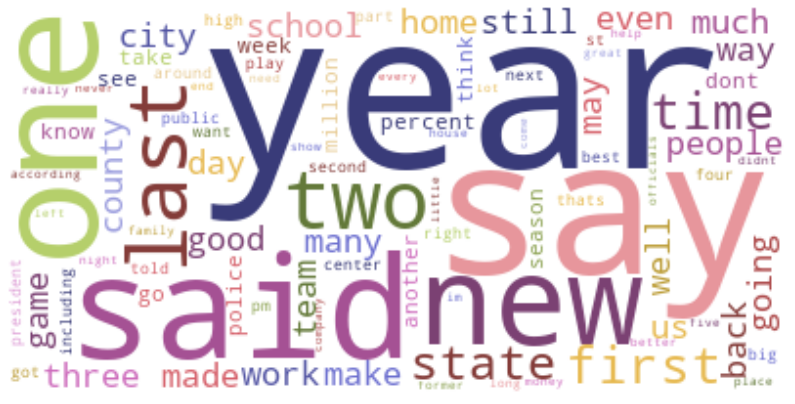

In [89]:
df = spark.sql(""" SELECT items 
                   FROM frequent_itemsets
                   WHERE size(items) = 1
                   ORDER BY freq desc
                   LIMIT 100 """)

# collecting and flattening the output
df2 = df.rdd.flatMap(lambda x : x).collect()
fullStr = ' '.join(''.join(l) for l in df2)

# generating the wordcloud
wordcloud = WordCloud(background_color='white', colormap='tab20b').generate(fullStr)

# displaying the generated image
plt.figure(figsize = (14, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show();